<a href="https://colab.research.google.com/github/sychun/colab/blob/master/ycn_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
readD = pd.read_csv('/content/gdrive/My Drive/colab-data-files/train_data_ycn_pcat.csv')
readD = readD.drop(columns= ['apt_size', 'seo_ratio', 'contract_date'])
# readD.info()
# readD.head()

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, test_idx in split.split(readD, readD["price_cat"]): # readD['price_cat'] 분포 유지
    train_set = readD.loc[train_idx]
    test_set = readD.loc[test_idx]

In [5]:
for set_ in (train_set, test_set):
    set_.drop('price_cat', axis=1, inplace=True)

In [6]:
X_train = train_set.drop('ppp_cv', axis=1)
train_targets = train_set['ppp_cv'].copy()
X_test =  test_set.drop('ppp_cv', axis=1)
test_targets = test_set['ppp_cv'].copy()

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

data_pipeline = Pipeline([
        ('selector', DataFrameSelector(list(X_train))),
        ('std_scaler', StandardScaler()),
    ])

train_data = data_pipeline.fit_transform(X_train)
test_data = data_pipeline.fit_transform(X_test)

In [9]:
import tensorflow as tf
import tensorflow.keras as keras

In [10]:
train_data.shape

(23857, 14)

In [11]:
test_data.shape

(10225, 14)

In [12]:
train_targets

2142     25362969
3231     32575608
5831     28783980
8178     28175064
8090     25462186
           ...   
3143     12139943
28682    45496324
25020    16935441
21799    27504725
16182    34593097
Name: ppp_cv, Length: 23857, dtype: int64

In [13]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [15]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 16
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [16]:
all_scores

[6398951.5, 6519617.0, 6420438.0, 6555697.0]

In [17]:
np.mean(all_scores)

6473675.875

In [18]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [19]:
num_epochs = 50
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [20]:
# history.history.keys()

In [21]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [22]:
import matplotlib.pyplot as plt

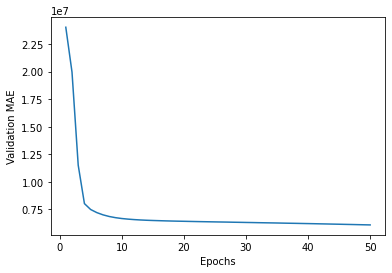

In [23]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

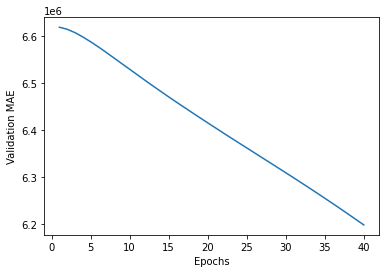

In [24]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [25]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

320/320 [==============================] - 1s 2ms/step - loss: 76935195525120.0000 - mae: 6618379.0000


In [26]:
test_mae_score

6618379.0